In [54]:
import torch
from torch import tensor
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np

In [55]:
class FairLogReg(nn.Module):
    def __init__(self, D, warm_start = None):
        super(FairLogReg, self).__init__()
        if warm_start is not None:
            self.theta = torch.nn.Parameter(warm_start, requires_grad=True)
        else:
            self.theta = torch.nn.Parameter(torch.zeros(D), requires_grad=True)
        self.old_theta = tensor(float("Inf"))

    def forward(self, x):
        return x.mv(self.theta)


Pick between COMPAS and Adult data sets

In [56]:
# Comment one out

def get_data(filename):
    df = pd.read_csv("data/COMPAS/" + filename + ".csv")
    s = tensor(df['race'] == "Caucasian")
    y = tensor(df['two_year_recid'] == 0).float()
    X = tensor(df.drop(columns=['race','sex','sex-race','two_year_recid']).values).float()
    X = torch.cat((torch.ones(X.shape[0],1), X), dim=1)
    return (X,y,s)
lam_regs = 2. ** np.array([-3, -3, -3, -3, -3])

# def get_data(filename):
#     df = pd.read_csv("data/Adult/" + filename + ".csv")
#     s = tensor(df['sex'] == "Male")
#     y = tensor(df['income-per-year'] == ">50K").float()
#     X = tensor(df.drop(columns=['sex','race','income-per-year','race-sex','capital-gain', 'capital-loss']).values).float()
#     X = torch.cat((torch.ones(X.shape[0],1), X), dim=1)
#     return (X,y,s)
# lam_regs = 2. ** np.array([-14, -12, -12, -12, -13])

In [57]:
form="logistic"
sum_form=1 # 1 for sum, -1 for difference
eoo=False

In [58]:
if form == "logistic":
    def g(outputs):
        return -F.logsigmoid(-outputs).sum()
elif form == "hinge":
    relu = torch.nn.ReLU()
    def g(outputs):
        return relu(outputs+1).sum()
elif form == "linear":
    def g(outputs):
        return outputs.sum()
else:
    raise ValueError("Pick a valid form!")

ploss = nn.BCEWithLogitsLoss()
def floss(outputs, sens_attr, Pa, Pb):
    return sum_form * g(sum_form * outputs[sens_attr])/Pa + g(- outputs[~sens_attr])/Pb

In [59]:
(Xs, ys, ss) = ([None] * 5, [None] * 5, [None] * 5)
(Xts, yts, sts) = ([None] * 5, [None] * 5, [None] * 5)
for i in range(5):
    (Xs[i], ys[i], ss[i]) = get_data("train" + str(i))
    (Xts[i], yts[i], sts[i]) = get_data("test" + str(i))

In [60]:
def make_closure(model, optimizer, lam_fair, lam_reg, X, y, s, Pa, Pb):
    def closure():
        assert not torch.isnan(model.theta).any()
        optimizer.zero_grad()
        outputs = model(X)
        if eoo:
            loss = ploss(outputs,y) + lam_reg * (model.theta**2).mean() + lam_fair/outputs.shape[0] * floss(outputs[y.bool()], s[y.bool()], Pa, Pb)
        else:
            loss = ploss(outputs,y) + lam_reg * (model.theta**2).mean() + lam_fair/outputs.shape[0] * floss(outputs, s, Pa, Pb)
        loss.backward()
        return loss
    return closure

In [61]:
def train_model(X,y,s,lam_fair=0, lam_reg=0, warm_start=None):
    if eoo:
        (Pa, Pb) = ((s & y.bool()).float().mean(), (~s&y.bool()).float().mean())
    else:
        (Pa, Pb) = (s.float().mean(), 1 - s.float().mean())
    model = FairLogReg(X.shape[1], warm_start=warm_start)
    if form == "hingexxx":
        optimizer = optim.Adam(model.parameters(), lr=1)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    else:
        optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
    closure = make_closure(model, optimizer, lam_fair, lam_reg, X, y, s, Pa, Pb)
    for t in trange(500):
        loss = optimizer.step(closure)
        if form == "hingexxx":
            scheduler.step(loss)
        diff = (model.old_theta - model.theta).abs().max()
        if diff < 1e-10:
            break
        model.old_theta = model.theta.clone().detach()
    return (model, t)

In [62]:
def get_summary(model, X,y,s, lam_fair=0, lam_reg=0):
    (Pa, Pb) = (s.float().mean(), 1 - s.float().mean())
    outputs = model(X)
    accuracy = (y == (outputs >= 0)).float().mean()
    if eoo:
        unfairness = (outputs[y.bool() & s] >= 0).float().mean() - (outputs[y.bool() & ~s] >= 0).float().mean()
        relaxation = 1/outputs.shape[0] * floss(outputs[y.bool()], s[y.bool()], Pa, Pb)
    else:
        unfairness = (outputs[s] >= 0).float().mean() - (outputs[~s] >= 0).float().mean()
        relaxation = 1/outputs.shape[0] * floss(outputs, s, Pa, Pb)
    loss = ploss(outputs,y)
    return(accuracy, unfairness, loss, relaxation)

In [63]:
# for weighting baseline, if desired
def get_weighed_loss(X,y,s):
    wobs = y * 10 + s
    wobs[wobs==0.] = (wobs==0.).float().mean()
    wobs[wobs==1.] = (wobs==1.).float().mean()
    wobs[wobs==11.] = (wobs==11.).float().mean()
    wobs[wobs==10.] = (wobs==10.).float().mean()
    wy = (y - (y==0).float().mean()).abs()
    ws = (s.float() - (s==0).float().mean()).abs()
    wexp = ws * wy
    return nn.BCEWithLogitsLoss(weight = (wexp/wobs))

In [70]:
df = pd.DataFrame(columns = ['Split', 'Lam_fair', 'Type', 'Accuracy', 'Unfairness', 'Ploss', 'Relaxation'])
warm_starts = [None] * 5
lfs =  np.arange(0, 2, 0.1) #0.02)
for lam_fair in lfs:
    for i in range(5):
        (model,t) = train_model(Xs[i],ys[i],ss[i], lam_fair = lam_fair, lam_reg = lam_regs[i], warm_start=warm_starts[i])
     #    (model,t) = train_model(Xs[i],ys[i],ss[i], lam_fair = lam_fair, lam_reg = 0, warm_start=warm_starts[i])
        warm_starts[i] = model.theta.clone().detach()
        (train_accuracy, train_unfairness, train_loss, train_relax) = get_summary(model, Xs[i], ys[i], ss[i], lam_fair = lam_fair, lam_reg = lam_regs[i])
        d = {"Split": [i],
             "Type": ["Train"],
             "Lam_fair": [lam_fair.item()],
             'Accuracy': [train_accuracy.item()], 
             'Unfairness': [train_unfairness.item()],
             'Ploss': [train_loss.item()],
             'Relaxation': [train_relax.item()]}
        df = pd.concat([df, pd.DataFrame(d)], axis=0, ignore_index=True)
        (test_accuracy, test_unfairness, test_loss, test_relax) = get_summary(model, Xts[i], yts[i], sts[i], lam_fair = lam_fair, lam_reg = lam_regs[i])
        d = {"Split": [i],
             "Type": ["Test"],
             "Lam_fair": [lam_fair.item()],
             'Accuracy': [test_accuracy.item()], 
             'Unfairness': [test_unfairness.item()],
             'Ploss': [test_loss.item()],
             'Relaxation': [test_relax.item()]}
        df = pd.concat([df, pd.DataFrame(d)], axis=0, ignore_index=True)
    print(lam_fair)


  4%|▍         | 22/500 [00:00<00:06, 74.87it/s]


0.0


  2%|▏         | 10/500 [00:00<00:12, 38.42it/s]


0.1


  4%|▍         | 19/500 [00:00<00:06, 71.80it/s]


0.2


  4%|▍         | 20/500 [00:00<00:05, 81.14it/s]


0.30000000000000004


  4%|▍         | 21/500 [00:00<00:06, 72.88it/s]


0.4


  5%|▍         | 23/500 [00:00<00:05, 86.06it/s] 


0.5


  4%|▍         | 21/500 [00:00<00:06, 77.79it/s]


0.6000000000000001


  5%|▌         | 26/500 [00:00<00:04, 103.42it/s]


0.7000000000000001


  5%|▍         | 23/500 [00:00<00:05, 91.68it/s] 


0.8


  3%|▎         | 13/500 [00:00<00:09, 52.21it/s]


0.9


  5%|▍         | 23/500 [00:00<00:05, 89.68it/s]


1.0


  7%|▋         | 35/500 [00:00<00:03, 123.44it/s]


1.1


  4%|▍         | 21/500 [00:00<00:06, 79.46it/s]


1.2000000000000002


  3%|▎         | 17/500 [00:00<00:07, 63.79it/s]


1.3


  5%|▌         | 26/500 [00:00<00:04, 96.89it/s] 


1.4000000000000001


  5%|▌         | 26/500 [00:00<00:04, 95.26it/s]


1.5


  4%|▍         | 21/500 [00:00<00:06, 78.92it/s]


1.6


  4%|▍         | 21/500 [00:00<00:06, 78.69it/s]


1.7000000000000002


  4%|▍         | 22/500 [00:00<00:05, 86.37it/s]


1.8


  4%|▍         | 22/500 [00:00<00:05, 87.79it/s]

1.9000000000000001


In [71]:
df

,Split,Lam_fair,Type,Accuracy,Unfairness,Ploss,Relaxation
0,0,0.0,Train,0.695923,0.240030,0.585493,1.811931
1,0,0.0,Test,0.651350,0.183174,0.617117,1.762440
2,1,0.0,Train,0.696489,0.200167,0.589252,1.779047
3,1,0.0,Test,0.656519,0.221317,0.610180,1.775146
4,2,0.0,Train,0.694224,0.223260,0.594406,1.773989
...,...,...,...,...,...,...,...
195,2,1.9,Test,0.414130,-0.256893,0.785455,1.283332
196,3,1.9,Train,0.433749,-0.363858,0.775140,1.208793
197,3,1.9,Test,0.415279,-0.254844,0.791043,1.293496
198,4,1.9,Train,0.421857,-0.377383,0.781414,1.209324


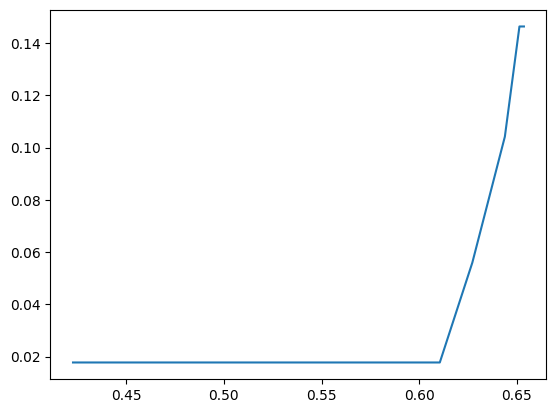

In [72]:
import matplotlib.pyplot as plt
df_0 = df.loc[(df['Split']==0) & (df['Type']=='Test')].copy()
df_0['Unfairness'] = np.abs(df_0['Unfairness'])
df_0 = df_0.sort_values(by='Accuracy')
unfairness_vals = df_0['Unfairness'].values
min_unfairness = [np.min(unfairness_vals[i:]) for i in range(len(unfairness_vals))]
plt.plot(df_0['Accuracy'], min_unfairness)




In [73]:
Xs[0].shape

torch.Size([3532, 400])